In [1]:
import cv2
import os
import tqdm

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

In [13]:
import torch

from torchvision import transforms as tr
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import center_crop, to_pil_image, resize

from torchvision import models
from torch import nn

from einops import rearrange

from torchcam.methods import SmoothGradCAMpp
from torchcam.utils import overlay_mask

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Constants

In [5]:
RANDOM_STATE = 432

PICTURES_DIR = "/home/dude/tongue-net/data/pictures"
MASKS_DIR = "/home/dude/tongue-net/data/predicted-masks"

DEVICE = torch.device('cuda:0')

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512

BATCH_SIZE = 64

# Dataset

In [7]:
annotation_df = pd.read_csv(f"{PICTURES_DIR}/annotation.tsv", sep="\t")
annotation_df = annotation_df.dropna()

In [9]:
annotation_df = annotation_df.rename(columns={"Name": "Image"})
annotation_df["Mask"] = annotation_df["Image"]
annotation_df = annotation_df[[
    "Root", "Image", "Mask", "Class"
]].dropna()
annotation_df.index = range(len(annotation_df))

In [21]:
annotation_df.head()

,Root,Image,Mask,Class
0,Рак языка/№18,5_2024-02-06 22-46-55 (4).jpeg,5_2024-02-06 22-46-55 (4).jpeg,1.0
1,Рак языка/№18,5_2024-02-06 22-46-55 (3).jpeg,5_2024-02-06 22-46-55 (3).jpeg,1.0
2,Рак языка/№18,5_2024-02-06 22-46-55 (1).jpeg,5_2024-02-06 22-46-55 (1).jpeg,1.0
3,Рак языка/№18,5_2024-02-06 22-46-55 (5).jpeg,5_2024-02-06 22-46-55 (5).jpeg,1.0
4,Рак языка/№18,5_2024-02-06 22-46-55 (2).jpeg,5_2024-02-06 22-46-55 (2).jpeg,1.0


In [10]:
train_df, val_df = train_test_split(
    annotation_df,
    test_size=0.3, train_size=0.7,
    stratify=annotation_df["Class"],
    random_state=RANDOM_STATE,
    shuffle=True
)

### Stats of dataset

In [10]:
# means, stds = [], []
# for _, row in tqdm.tqdm(train_df.iterrows(), total=len(train_df)):
#     image = cv2.imread(f"{PICTURES_DIR}/{row['Root']}/{row['Image']}")
    
#     means.append(np.mean(np.array(image) / 255., axis=(0, 1)))
#     stds.append(np.std(np.array(image) / 255., axis=(0, 1)))

# channel_mean = np.median(means, axis=0)
# channel_std = np.median(stds, axis=0)

100%|█████████████████████████████████████████| 392/392 [04:53<00:00,  1.33it/s]


In [11]:
# print(channel_mean)
# print(channel_std)

[0.44465111 0.46566397 0.58495675]
[0.19845937 0.20769345 0.22408782]


In [11]:
channel_mean = np.array([0.44465111, 0.46566397, 0.58495675])[[2, 1, 0]]
channel_std = np.array([0.19845937, 0.20769345, 0.22408782])[[2, 1, 0]]

### Prepare and transform

In [17]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

class RandomCenterCrop(object):
    def __init__(self, height, width):
        self.height = height
        self.width = width

    def __call__(self, tensor):
        proba = torch.rand(1)
        
        height, width = tensor.shape[1:]
        height_ = int(self.height * proba + (1 - proba) * height)
        width_ = int(self.width * proba + (1 - proba) * width)
        
        return center_crop(tensor, (height_, width_))

def de_normalize(img):
    return rearrange(minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        axis=1,
    ), "layer (height width) -> height width layer", height=IMAGE_HEIGHT)

In [18]:
prepare = tr.Compose([
    tr.ToPILImage(),
    tr.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    tr.ToTensor(),
    tr.Normalize(channel_mean, channel_std),
])

transform = tr.Compose([
    tr.RandomHorizontalFlip(), 
    tr.RandomRotation(degrees=(-20, 20)),
    RandomCenterCrop(int(IMAGE_HEIGHT * 0.7), int(IMAGE_HEIGHT * 0.7)),
    tr.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    AddGaussianNoise(0., 1e-2)
])

### Normalization checks

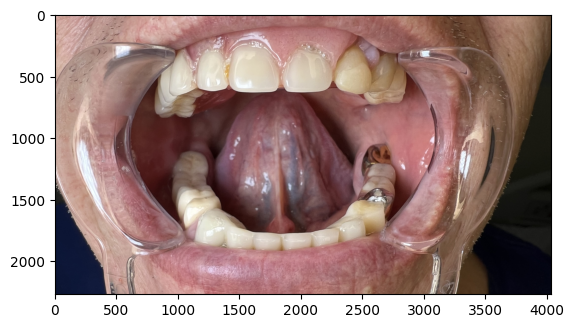

In [41]:
row = train_df.iloc[97]
image = cv2.imread(f"{PICTURES_DIR}/{row['Root']}/{row['Image']}")[:, :, [2, 1, 0]]
plt.imshow(image)

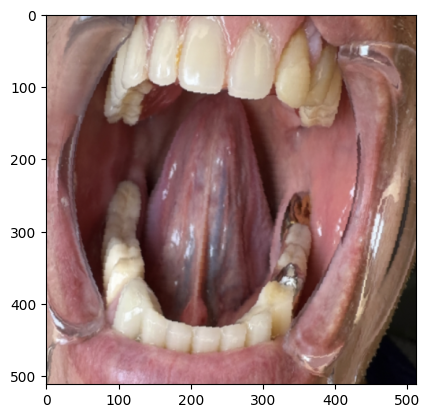

In [42]:
plt.imshow(de_normalize(transform(prepare(image))))

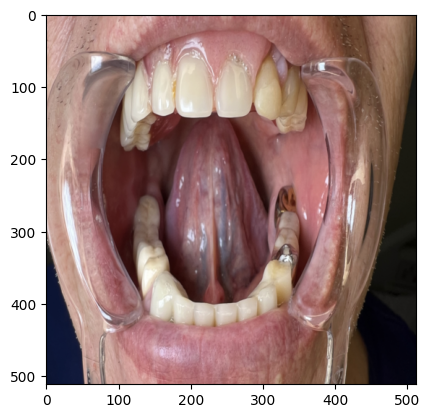

In [43]:
plt.imshow(de_normalize(prepare(image)))

### Dataset

In [22]:
class TongueDataset(Dataset):
    def __init__(self, annotation, prepare=None, transform=None):
        super(TongueDataset).__init__()
        
        self.annotation = annotation

        self.prepare = prepare
        self.transform = transform

        self.images = []
        self.classes = []

        transfromer = tr.Compose([
            tr.ToPILImage(),
            tr.ToTensor(),
        ])
        
        for _, row in tqdm.tqdm(self.annotation.iterrows(), total=len(self.annotation)):
            image = cv2.imread(f"{PICTURES_DIR}/{row['Root']}/{row['Image']}")
            mask = cv2.imread(f"{MASKS_DIR}/{row['Root']}/{row['Mask']}")

            if image is None or mask is None:
                print(row['Root'], row['Mask'], row['Image'], "-- None")
            else:
                image = image[:, :, [2, 1, 0]]
                mask = mask[:, :, [2, 1, 0]]
  
            # Mask preparation
            image = transfromer(image)
            mask = transfromer(mask)

            if mask.shape[1:] != image.shape[1:]:
                mask = tr.Resize(image.shape[1:])(mask)

            # Mask extraction
            image = image * mask
            
            if prepare is None:
                self.images.append(image)
            else:
                self.images.append(prepare(image))

            self.classes.append(row["Class"])
  
    def __getitem__(self, index):
        image_, class_ = self.images[index], self.classes[index]
    
        if self.transform is not None:
            image_ = self.transform(image_)

        return image_, class_
    
    def __len__(self):
        return len(self.images)

In [23]:
train_dataset = TongueDataset(
    train_df,
    prepare=prepare,
    transform=transform
)

val_dataset = TongueDataset(
    val_df,
    prepare=prepare,
    transform=None
)

  1%|▍                                          | 4/393 [00:02<04:47,  1.35it/s]


Рак языка/№25 IMG_4812.HEIC IMG_4812.HEIC -- None


TypeError: pic should be Tensor or ndarray. Got <class 'NoneType'>.

In [46]:
def collate_fn(batch):
    images_ = torch.stack([image_ for image_, _ in batch]).to(DEVICE)
    classes_ = torch.tensor([int(class_) for _, class_ in batch]).to(DEVICE)
    
    return images_, classes_

dataloader_train = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

dataloader_val = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
)

### Some more checks

In [95]:
def de_normalize(img):
    return rearrange(minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        axis=1,
    ), "layer (height width) -> height width layer", height=IMAGE_HEIGHT)

1.0


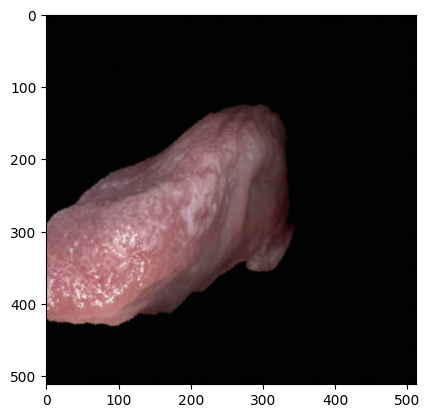

In [47]:
image_, class_ = train_dataset[np.random.randint(len(train_dataset))]
print(class_)
plt.imshow(de_normalize(image_))

1.0


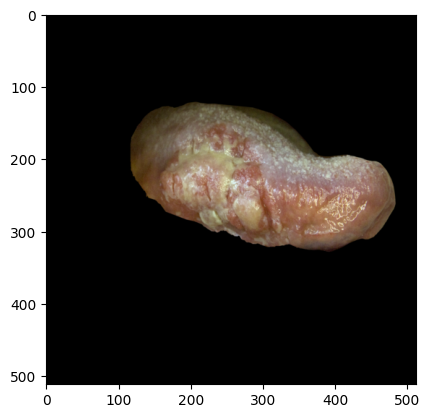

In [48]:
image_, class_ = val_dataset[np.random.randint(len(val_dataset))]
print(class_)
plt.imshow(de_normalize(image_))

# Model

In [49]:
from collections import OrderedDict

class TongueCancerClassifier(nn.Module):
    def __init__(self):
        super(TongueCancerClassifier, self).__init__()
        
        weights = models.ResNet18_Weights.DEFAULT
        self.model = models.resnet18(weights=weights, progress=True)
        
        self.model.fc = nn.Sequential(OrderedDict([
            ('linear', nn.Linear(self.model.fc.in_features, 2)),
            ('log_soft', nn.LogSoftmax(dim=-1)),
        ]))

    def forward(self, imgs):
        return self.model(imgs)

# Training

In [50]:
from termcolor import colored
from collections import defaultdict

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    
    for name, param in model.named_parameters():
        num_params = np.prod(param.shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
            
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
            
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )
    
    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
        
    return sum_params, sum_learnable_params

model = TongueCancerClassifier()
sum_params, sum_learnable_params = model_num_params(model)

model.conv1.weight                         ~  9.408     params ~ grad: True
model.bn1.weight                           ~  64        params ~ grad: True
model.bn1.bias                             ~  64        params ~ grad: True
model.layer1.0.conv1.weight                ~  36.864    params ~ grad: True
model.layer1.0.bn1.weight                  ~  64        params ~ grad: True
model.layer1.0.bn1.bias                    ~  64        params ~ grad: True
model.layer1.0.conv2.weight                ~  36.864    params ~ grad: True
model.layer1.0.bn2.weight                  ~  64        params ~ grad: True
model.layer1.0.bn2.bias                    ~  64        params ~ grad: True
model.layer1.1.conv1.weight                ~  36.864    params ~ grad: True
model.layer1.1.bn1.weight                  ~  64        params ~ grad: True
model.layer1.1.bn1.bias                    ~  64        params ~ grad: True
model.layer1.1.conv2.weight                ~  36.864    params ~ grad: True
model.layer1

In [51]:
# temp_weights = models.ResNet18_Weights.DEFAULT
# temp_model = models.resnet18(weights=temp_weights, progress=True)

# model_num_params(temp_model)

In [52]:
def create_model_and_optimizer(model_class, model_params, lr, device):
    model = model_class(**model_params)
    model = model.to(device)
    
    trainable_params = [param for param in model.parameters() if param.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr)
    return model, optimizer

In [53]:
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    
    losses_tr = []
    for imgs, targets in tqdm.tqdm(loader):
        optimizer.zero_grad()
        preds = model(imgs)
        loss = criterion(preds, targets)
        
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)

def val(model, loader, criterion, metric_names=None):
    model.eval()
    
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
        
    with torch.no_grad():
        for imgs, targets in tqdm.tqdm(loader):
            preds = model(imgs)
            loss = criterion(preds, targets)

            losses_val.append(loss.item())
            
            if metric_names is not None:
                targets_ = np.array(targets.cpu()).flatten()
                preds_ = np.array(torch.argmax(preds, dim=1).cpu()).flatten()
                
                matrix = confusion_matrix(targets_, preds_)
                
                if 'accuracy' in metric_names:    
                    metrics['accuracy'].append(
                        (matrix[0][0] + matrix[1][1]) / matrix.sum()
                    )

                if 'sensitivity' in metric_names:    
                    metrics['sensitivity'].append(
                         0 if not matrix[1][1] else matrix[1][1] / matrix[:, 1].sum()
                    )

                if 'specificity' in metric_names:    
                    metrics['specificity'].append(
                        0 if not matrix[0][0] else matrix[0][0] / matrix[:, 0].sum()
                    )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])
    
    return np.mean(losses_val), metrics if metric_names else None

In [54]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=50,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):
    # Save
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed = True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
        
    # Init
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()

    # Train
    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)
            
            if loss < best_val_loss:
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name + '.pt'),
                )
                best_val_loss = loss
            
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot_id", 1), metric_meta]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(isinstance(el[1], int) for el in plot_ids_)
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                assert all(el[1] >= 1 for el in plot_ids_)
                
                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append((el[0], el[2]))
                
            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(30, 10))
            fig.suptitle(f'#{epoch}/{epochs} ~ {timedelta(seconds=time.monotonic() - start_time)}')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()
            
            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.yscale("log")
            plt.legend()
            plt.grid()
            
            if metric_names is not None:
                for plot_id, keys_meta in plot_ids.items():
                    aggregated_meta = {}
                    plt.subplot(1, ww + ww_metrics, ww + plot_id)
                    if len(keys_meta) > 1:
                        plt.title(f'additional metrics #{plot_id}')
                    elif len(keys_meta) == 1:
                        plt.title(keys_meta[0][0])
                    for key_meta in keys_meta:
                        key, meta = key_meta
                        for meta_key in ["yscale"]:
                            if meta_key in meta:
                                assert meta_key not in aggregated_meta, f"Bad meta data '{meta_key}' doubled inside one plot_id ({plot_id})"
                                aggregated_meta[meta_key] = meta[meta_key]
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                    plt.yscale(aggregated_meta.get("yscale", "linear"))
                    plt.legend()
                    plt.grid()
            plt.show()
        
        # early_stopping - останавливаем обучение, если LR упал ниже min_lr
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break
    
    return model, optimizer, losses

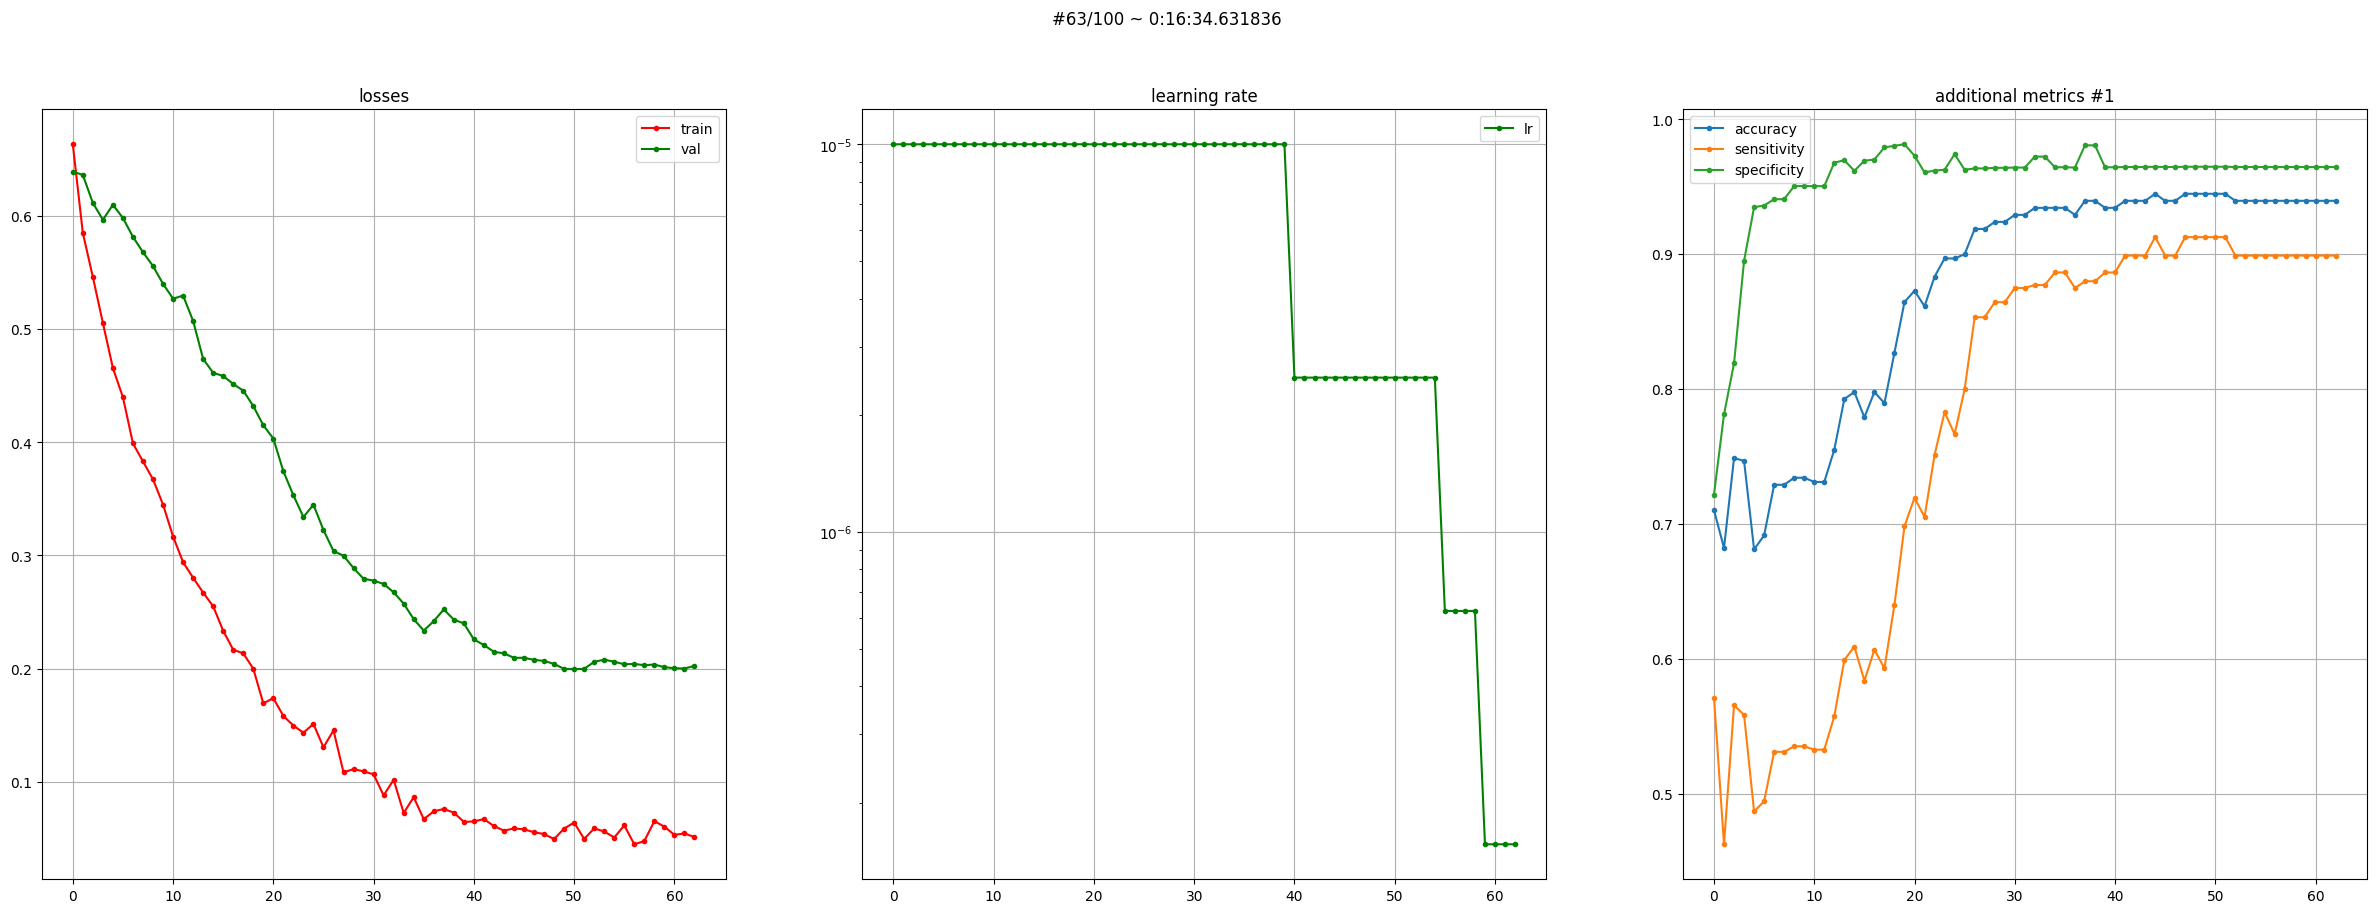

Learning process ended with early stop after epoch 63
CPU times: user 1h 3min 4s, sys: 1min 58s, total: 1h 5min 3s
Wall time: 16min 36s


In [56]:
%%time

device = DEVICE

model, optimizer = create_model_and_optimizer(
    model_class=TongueCancerClassifier,
    model_params={},
    lr=1e-5,
    device=device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.25,
    patience=3,
    threshold=1e-4,
    verbose=True
)

criterion = nn.NLLLoss()

model, optimizer, losses = learning_loop(
    model=model,
    optimizer=optimizer,
    train_loader=dataloader_train,
    val_loader=dataloader_val,
    criterion=criterion,
    scheduler=scheduler,
    epochs=100,
    min_lr=1e-7,
    val_every=1,
    draw_every=1,
    separate_show=False,
    metric_names={
        "accuracy": {"plot_id": 1},
        "sensitivity": {"plot_id": 1},
        "specificity": {"plot_id": 1},
    },
    chkp_folder="./chkp",
    model_name="resnet-masked-manual",
)

# Inference

## Load model

In [57]:
model_name = "resnet-masked-manual#0"
checkpoint = torch.load(os.path.join("./chkp", f"{model_name}.pt"))

device = torch.device('cuda:0')

model, optimizer = create_model_and_optimizer(
    model_class=TongueCancerClassifier,
    model_params={},
    lr=1e-5,
    device=device,
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.25,
    patience=3,
    threshold=1e-4,
    verbose=True
)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']

model = model.eval()

## Evaluation

In [58]:
true_, predicted_ = [], []
for img, tg in tqdm.tqdm(val_dataset):
    true_.append(tg)
    predicted_.append(
        torch.exp(
            model(img.to(device).unsqueeze(0)).squeeze(0)
        )[1].item()
    )

100%|█████████████████████████████████████████| 168/168 [00:01<00:00, 94.94it/s]


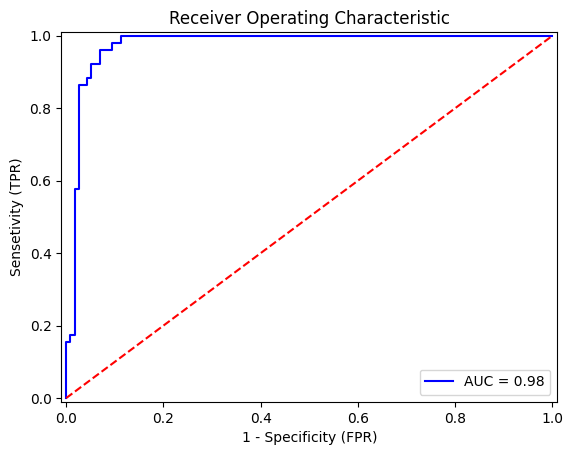

In [59]:
fpr_, tpr_, thresholds_ = roc_curve(true_, predicted_)
auc_ = auc(fpr_, tpr_)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_, tpr_, 'b', label = 'AUC = %0.2f' % auc_)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim((0 - 1e-2, 1 + 1e-2))
plt.ylim((0 - 1e-2, 1 + 1e-2))
plt.ylabel('Sensetivity (TPR)')
plt.xlabel('1 - Specificity (FPR)')
plt.show()

## Interpretation

In [24]:
# class_ = 0 # healthy
class_ = 1 # tumor
indexes = [i for i in range(len(val_dataset)) if val_dataset[i][1] == class_]
indexes = np.random.choice(indexes, size=(3, 4))

fig, ax = plt.subplots(3, 4, figsize=(30, 22))
for row in range(3):
    for col in range(2): 
        with SmoothGradCAMpp(model, target_layer='model.layer4') as extractor:
            img, _ = val_dataset[indexes[row][col]]
            output = model(img.to(device).unsqueeze(0))
            activation = extractor(output.squeeze(0).argmax().item(), output)
            
            ax[row][col * 2].imshow(center_crop(
                overlay_mask(
                    to_pil_image(de_normalize(img)),
                    to_pil_image(activation[0].squeeze(0), mode='F')),
                (int(IMAGE_HEIGHT * 0.7), int(IMAGE_HEIGHT * 0.7))))
            
            ax[row][col * 2 + 1].imshow(center_crop(
                to_pil_image(de_normalize(img)),
                (int(IMAGE_HEIGHT * 0.7), int(IMAGE_HEIGHT * 0.7))))
            
            ax[row][col * 2].axis("off")
            ax[row][col * 2 + 1].axis("off")

fig.tight_layout()
fig.show()

NameError: name 'val_dataset' is not defined

In [ ]:
# class_ = 0 # healthy
class_ = 1 # tumor
indexes = [i for i in range(len(val_dataset)) if val_dataset[i][1] == class_]
indexes = np.random.choice(indexes, size=(3, 4))

fig, ax = plt.subplots(3, 4, figsize=(30, 22))
for row in range(3):
    for col in range(2): 
        with SmoothGradCAMpp(model, target_layer='model.layer4') as extractor:
            img, _ = val_dataset[indexes[row][col]]
            output = model(img.to(device).unsqueeze(0))
            activation = extractor(output.squeeze(0).argmax().item(), output)
            
            ax[row][col * 2].imshow(center_crop(
                overlay_mask(
                    to_pil_image(de_normalize(img)),
                    to_pil_image(activation[0].squeeze(0), mode='F')),
                (int(IMAGE_HEIGHT * 0.7), int(IMAGE_HEIGHT * 0.7))))
            
            ax[row][col * 2 + 1].imshow(center_crop(
                to_pil_image(de_normalize(img)),
                (int(IMAGE_HEIGHT * 0.7), int(IMAGE_HEIGHT * 0.7))))
            
            ax[row][col * 2].axis("off")
            ax[row][col * 2 + 1].axis("off")

fig.tight_layout()
fig.show()